<a href="https://colab.research.google.com/github/h-j-hyun/NCoin-DP/blob/main/OU_n%3D2000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# Number of data points
n = 2000

# time inteval
delta = 1/12

# Generating x
obtime = np.arange(0,n+1)/n * n * delta

In [18]:
def OU_simul_sample(L_OU, time_OU, y0_OU, mu_OU, theta_OU, sigma_OU):
    """
    This function generates a sample path for OU process
    L_OU: number of simulation number
    y0: initial value 
    t: time array including initial point 
    mu, theta, sigma are parameters of OU process dX_t = theta (mu - X_t)dt + sigma dBt
    """
    z0 = y0_OU
    path_OU = torch.zeros(L_OU, time_OU.size)
    for l in range(time_OU.size-1):
      del_L = time_OU[l+1] - time_OU[l]
      OU_mean = z0 * torch.exp(-mu_OU * del_L) + theta_OU * (1- torch.exp(-mu_OU * del_L))
      OU_sd = torch.sqrt( sigma_OU**2/(2*mu_OU) * (1- torch.exp(-2 * mu_OU * del_L)) )
      z0 = torch.normal(OU_mean, OU_sd)
      path_OU[:,l] = z0
    return(path_OU)

In [19]:
L = 100000
Lval = 20000
Ltest = 10000

p = 3
mu_range = [1, 5]# True mu = 3
theta_range = [1, 2.5]# True theta = 2
sigma_range = [0.5, 2]# True sigma = 1

# Training + validation + Test data generating
torch.manual_seed(510)
mu_ran    = torch.rand(L) * (mu_range[1] -  mu_range[0]) + mu_range[0]  
theta_ran = torch.rand(L) * (theta_range[1] -  theta_range[0]) + theta_range[0]
sigma_ran = torch.rand(L) * (sigma_range[1] -  sigma_range[0]) + sigma_range[0]

# Output: L x 3 matrix
output = torch.stack((mu_ran, theta_ran, sigma_ran), dim = 1)
print(output.size())

torch.Size([100000, 3])


In [20]:
# Generating the y simulated
# It can take about a minute.
torch.manual_seed(511)
y0_tmp = torch.normal(theta_ran, torch.sqrt(sigma_ran**2/(2*mu_ran)))

yL = OU_simul_sample(L, obtime, y0_tmp, mu_ran, theta_ran, sigma_ran)
print(yL.size())

torch.Size([100000, 2001])


In [21]:
def moment_L(X):
    """
    X: torch size: [L,n]
    """
    L0 = X.size()[0]
    n0 = X.size()[1]

    sum1 = torch.zeros(L0) # sum x_i x_{i-1}
    sum2 = torch.zeros(L0) # sum x_i
    sum3 = torch.zeros(L0) # sum x_{i-1}
    sum4 = torch.zeros(L0) # sum x_{i-1}^2
    sum5 = torch.zeros(L0) # sum x_{i}^2

    for l in range(n0-1):
      sum1 = sum1 + X[:,l+1] * X[:,l]
      sum2 = sum2 + X[:,l+1]
      sum3 = sum3 + X[:,l]
      sum4 = sum4 + torch.pow(X[:,l],2)
      sum5 = sum5 + torch.pow(X[:,l+1],2)

    return(torch.stack((sum1/n0, sum2/n0, sum3/n0, sum4/n0, sum5/n0) ,1))
tmp = moment_L(yL)

In [22]:
import torch
X = torch.clone(tmp)

In [24]:
X_train = X[range(0,L-Lval-Ltest),:]
y_train = output[range(0,L-Lval-Ltest),:]

X_val = X[range(L-Lval-Ltest,L-Ltest),:]
y_val = output[range(L-Lval-Ltest,L-Ltest),:]

X_test = X[range(L-Ltest,L),:]
y_test = output[range(L-Ltest,L),:]

print(X_train.size(), X_val.size(),X_test.size())

torch.Size([70000, 5]) torch.Size([20000, 5]) torch.Size([10000, 5])


In [25]:
import torch
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# Define the batch size
BATCH_SIZE = 64

# Use torch.utils.data to create a DataLoader 
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True)

In [40]:
import torch.nn as nn            # for torch.nn.Module, the parent object for PyTorch models
import torch.nn.functional as F  # for the activation function

# Create the model, loss function, and optimizer
D_in, H, H2, H3, D_out = 5, 64, 64, 64, 3

# Dropout rate
p1, p2, p3 = .2, .2, .2
torch.manual_seed(2725)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.bn1 = nn.BatchNorm1d(num_features=H)
        self.dn1 = nn.Dropout(p1)
        
        self.fc2 = nn.Linear(H, H2)
        self.bn2 = nn.BatchNorm1d(num_features=H2)
        self.dn1 = nn.Dropout(p2)
        
        self.fc3 = nn.Linear(H2, H3)
        self.bn3 = nn.BatchNorm1d(num_features=H3)
        self.dn1 = nn.Dropout(p3)
        
        self.fc4 = nn.Linear(H3, 3)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

net = Net()

In [41]:
# Get the dataset size for printing (it is equal to N_SAMPLES)
dataset_size = len(dataloader.dataset)

In [42]:
from google.colab import drive
drive.mount('/content/gdrive1')
model_save_name = 'OU_n2000_v17.pt'
path = F"/content/gdrive1/My Drive/Colab Notebooks/{model_save_name}" 

Drive already mounted at /content/gdrive1; to attempt to forcibly remount, call drive.mount("/content/gdrive1", force_remount=True).


In [43]:
# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

N_EPOCHS = 300
train_error_plt = []
val_error_plt = []

# Loop over epochs
for epoch in range(N_EPOCHS):
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        y_batch_pred = net(x_batch)
        loss = loss_fn(y_batch_pred, y_batch)
      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 ==0 and id_batch % 100 == 0:
            loss, current = loss.item(), (id_batch + 1)* len(x_batch)
            print(f"train_loss: {loss/BATCH_SIZE:>7f}  [{current:>5d}/{dataset_size:>5d}]")
    
    with torch.no_grad():
           net.eval()
           theta_pred_train = net(X_train)
           train_loss = loss_fn(theta_pred_train,y_train) / (L-Lval)
           train_error_plt = np.append(train_error_plt, train_loss)
           
           theta_pred_val = net(X_val)
           val_loss = loss_fn(y_val, theta_pred_val) / (Lval)
           val_error_plt = np.append(val_error_plt, val_loss)
           
    if epoch % 10 ==0:
        print(f"Epoch {epoch + 1}\n-------------------------------")
        print(f"train_loss {train_loss:>7f} val_loss {val_loss:>7f}")
        print(learning_rate)
            
    # Choose Best Model
    if val_error_plt[epoch] == np.min(val_error_plt):
         best=epoch
         torch.save(net.state_dict(), path)

    if epoch % 100 ==99:
        net.load_state_dict(torch.load(path))
        learning_rate = max(learning_rate * 1e-1, 1e-9)

train_loss: 18.876413  [   64/70000]
train_loss: 14.160526  [ 6464/70000]
train_loss: 10.787226  [12864/70000]
train_loss: 7.742290  [19264/70000]
train_loss: 5.872393  [25664/70000]
train_loss: 4.000759  [32064/70000]
train_loss: 2.938999  [38464/70000]
train_loss: 2.431846  [44864/70000]
train_loss: 1.452266  [51264/70000]
train_loss: 1.847185  [57664/70000]
train_loss: 0.887733  [64064/70000]
Epoch 1
-------------------------------
train_loss 0.754720 val_loss 0.856827
0.0001
train_loss: 0.065177  [   64/70000]
train_loss: 0.085088  [ 6464/70000]
train_loss: 0.132954  [12864/70000]
train_loss: 0.072597  [19264/70000]
train_loss: 0.069672  [25664/70000]
train_loss: 0.045776  [32064/70000]
train_loss: 0.067896  [38464/70000]
train_loss: 0.066139  [44864/70000]
train_loss: 0.071673  [51264/70000]
train_loss: 0.066242  [57664/70000]
train_loss: 0.058610  [64064/70000]
Epoch 11
-------------------------------
train_loss 0.057817 val_loss 0.067861
0.0001
train_loss: 0.153184  [   64/70000

0.05239928141236305
230


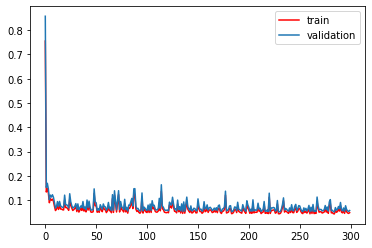

In [44]:
net.load_state_dict(torch.load(path))
print(np.min(val_error_plt))
print(np.argmin(val_error_plt))
plt.plot(np.arange(N_EPOCHS), train_error_plt, color = "r")
plt.plot(np.arange(N_EPOCHS), val_error_plt)
plt.legend(["train", "validation"], loc ="upper right")

In [63]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving sim_data_2000_1.csv to sim_data_2000_1.csv
Saving sim_data_2000_2.csv to sim_data_2000_2.csv
Saving sim_data_2000_3.csv to sim_data_2000_3.csv


In [72]:
import io
df1 = pd.read_csv(io.BytesIO(uploaded['sim_data_2000_1.csv']))
df2 = pd.read_csv(io.BytesIO(uploaded['sim_data_2000_2.csv']))
df3 = pd.read_csv(io.BytesIO(uploaded['sim_data_2000_3.csv']))

In [73]:
sim_data1= torch.tensor(df1.values.astype(np.float32))[:,1:(n+2)]
sim_data2= torch.tensor(df2.values.astype(np.float32))[:,1:(n+2)]
sim_data3= torch.tensor(df3.values.astype(np.float32))[:,1:(n+2)]
sim_data1_mom = moment_L(sim_data1)
sim_data2_mom = moment_L(sim_data2)
sim_data3_mom = moment_L(sim_data3)


torch.Size([500, 2001])


In [80]:
# Generate the simulation data to get the mean and standard deviation of estimated parameter
#sim = 2000

param1 = torch.Tensor([3, 2, 1])
param2 = torch.Tensor([4,1.5,1.5])
param3 = torch.Tensor([2,1.1,1.9])

sim_data1_mom = moment_L(sim_data1)
sim_data2_mom = moment_L(sim_data2)
sim_data3_mom = moment_L(sim_data3)

In [81]:
net.eval()
print(torch.mean(net(sim_data1_mom),0),torch.median(net(sim_data1_mom),0),torch.std(net(sim_data1_mom),0)) # (3,2,1)
print(torch.mean(net(sim_data2_mom),0),torch.median(net(sim_data2_mom),0),torch.std(net(sim_data2_mom),0)) # (4, 1.5, 1.5)
print(torch.mean(net(sim_data3_mom),0),torch.median(net(sim_data3_mom),0),torch.std(net(sim_data3_mom),0)) # (2, 1.1, 1.9#)

tensor([2.9916, 2.0002, 0.9958], grad_fn=<MeanBackward1>) torch.return_types.median(
values=tensor([2.9807, 1.9992, 0.9967], grad_fn=<MedianBackward1>),
indices=tensor([275, 120,  43])) tensor([0.1983, 0.0242, 0.0194], grad_fn=<StdBackward0>)
tensor([4.0248, 1.5039, 1.5094], grad_fn=<MeanBackward1>) torch.return_types.median(
values=tensor([4.0223, 1.5032, 1.5089], grad_fn=<MedianBackward1>),
indices=tensor([269,   3, 228])) tensor([0.2669, 0.0308, 0.0284], grad_fn=<StdBackward0>)
tensor([2.0460, 1.1381, 1.9066], grad_fn=<MeanBackward1>) torch.return_types.median(
values=tensor([2.0371, 1.1332, 1.9076], grad_fn=<MedianBackward1>),
indices=tensor([316, 264, 208])) tensor([0.1783, 0.0385, 0.0315], grad_fn=<StdBackward0>)


In [82]:
print(torch.sqrt((torch.sum(torch.square(net(sim_data1_mom)[:,0] - param1[0])) +torch.sum(torch.square(net(sim_data1_mom)[:,1] - param1[1])) +torch.sum(torch.square(net(sim_data1_mom)[:,2] - param1[2]))) /sim ) )
print(torch.sqrt((torch.sum(torch.square(net(sim_data2_mom)[:,0] - param2[0])) +torch.sum(torch.square(net(sim_data2_mom)[:,1] - param2[1])) +torch.sum(torch.square(net(sim_data2_mom)[:,2] - param2[2])))/sim) )
print(torch.sqrt((torch.sum(torch.square(net(sim_data3_mom)[:,0] - param3[0])) +torch.sum(torch.square(net(sim_data3_mom)[:,1] - param3[1])) +torch.sum(torch.square(net(sim_data3_mom)[:,2] - param3[2])))/sim))

tensor(0.2008, grad_fn=<SqrtBackward0>)
tensor(0.2712, grad_fn=<SqrtBackward0>)
tensor(0.1944, grad_fn=<SqrtBackward0>)


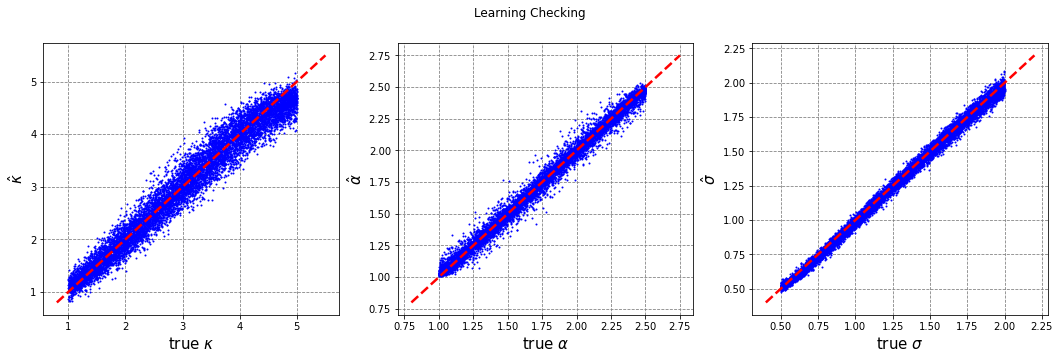

In [83]:
with torch.no_grad():
  net.eval()
  tmp1 = net(X_test)[:,0]
  tmp2 = net(X_test)[:,1]
  tmp3 = net(X_test)[:,2]

  tmp1 = tmp1.detach().cpu().numpy().tolist()
  tmp2 = tmp2.detach().cpu().numpy().tolist()
  tmp3 = tmp3.detach().cpu().numpy().tolist()




# Plot for model checking
lim1 = [mu_range[0] * 0.8, mu_range[1] * 1.1]
lim2 = [theta_range[0] * 0.8, theta_range[1] * 1.1]
lim3 = [sigma_range[0] * 0.8, sigma_range[1] * 1.1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
fig.suptitle('Learning Checking')

ax1.scatter(y_test[:,0], tmp1, marker='o', color='b', s = 1)
ax1.set_xlabel('true $\kappa$', fontsize=15)
ax1.set_ylabel('$\hat{\kappa}$', fontsize=15)
ax1.plot(np.linspace(lim1[0], lim1[1], 1000), np.linspace(lim1[0], lim1[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
ax1.set_axisbelow(True)
ax1.grid(color='gray', linestyle='dashed')

ax2.scatter(y_test[:,1], tmp2, marker='o', color='b', s = 1)
ax2.set_xlabel(r'true $\alpha$', fontsize=15 )
ax2.set_ylabel(r'$\hat{\alpha}$', fontsize=15)
ax2.plot(np.linspace(lim2[0], lim2[1], 1000), np.linspace(lim2[0], lim2[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
ax2.set_axisbelow(True)
ax2.grid(color='gray', linestyle='dashed')

ax3.scatter(y_test[:,2], tmp3, marker='o', color='b', s = 1)
ax3.set_xlabel('true $\sigma$', fontsize=15)
ax3.set_ylabel('$\hat{\sigma}$', fontsize=15)
ax3.plot(np.linspace(lim3[0], lim3[1], 1000), np.linspace(lim3[0], lim3[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
ax3.set_axisbelow(True)
ax3.grid(color='gray', linestyle='dashed')

plt.show()

In [84]:
def MLE_OU(sim_OU, obtime_OU, delta_OU):
  """
  sim_OU size : sim * n_OU
  """
  sim_num = sim_OU.size()[0]
  n_OU = len(obtime_OU)
  n0_OU = n_OU -1
  vec_xi = sim_OU[:, 1:]
  vec_xim1 = sim_OU[:, :n0_OU]
  beta1 = (torch.sum(vec_xi * vec_xim1,1) - 1/n0_OU * torch.sum(vec_xi, 1) * torch.sum(vec_xim1, 1) ) / (torch.sum(vec_xim1 ** 2, 1) - 1/n0_OU * (torch.sum(vec_xim1, 1))**2   ) # size : sim
  beta2 = 1/n0_OU * (  torch.sum(vec_xi,1) - beta1 * torch.sum(vec_xim1,1) ) / (torch.ones(sim_num)-beta1) # size: sim
  tmp1 =torch.transpose(torch.kron(beta1, torch.ones(n0_OU,1)),0,1 )
  tmp2 =torch.transpose(torch.kron(beta2 * (torch.ones(sim_num)-beta1), torch.ones(n0_OU,1)),0,1 )
  tmp_beta3 = (vec_xi - tmp1 * vec_xim1 - tmp2) # size: 
  beta3 = 1/n0_OU * torch.sum(tmp_beta3**2, 1)
  mu = -torch.ones(sim_num) * torch.log(beta1) / delta_OU
  alpha = beta2
  sigma = torch.sqrt(2 * mu * beta3 / (torch.ones(sim_num) - beta1 ** 2 )) 
  return(torch.stack((mu, alpha,sigma), 1))

results1_MLE = MLE_OU(sim_data1, obtime, delta)
results2_MLE = MLE_OU(sim_data2, obtime, delta)
results3_MLE = MLE_OU(sim_data3, obtime, delta)

print(torch.mean(results1_MLE,0),torch.std(results1_MLE,0) )
print(torch.mean(results2_MLE,0),torch.std(results2_MLE,0) )
print(torch.mean(results3_MLE,0),torch.std(results3_MLE,0) )
print(torch.sqrt((torch.sum(torch.square(results1_MLE[:,0] - param1[0])) +torch.sum(torch.square(results1_MLE[:,1] - param1[1])) +torch.sum(torch.square(results1_MLE[:,2] -param1[2]))) /sim ) )
print(torch.sqrt((torch.sum(torch.square(results2_MLE[:,0] - param2[0])) +torch.sum(torch.square(results2_MLE[:,1] - param2[1])) +torch.sum(torch.square(results2_MLE[:,2] -param2[2]))) /sim ) )
print(torch.sqrt((torch.sum(torch.square(results3_MLE[:,0] - param3[0])) +torch.sum(torch.square(results3_MLE[:,1] - param3[1])) +torch.sum(torch.square(results3_MLE[:,2] -param3[2]))) /sim ) )

tensor([3.0539, 1.9990, 1.0012]) tensor([0.2168, 0.0260, 0.0173])
tensor([4.0176, 1.5001, 1.5006]) tensor([0.2807, 0.0290, 0.0283])
tensor([2.0226, 1.0995, 1.9015]) tensor([0.1785, 0.0729, 0.0320])
tensor(0.2254)
tensor(0.2839)
tensor(0.1966)
